# Primo progetto di Social Computing

Il progetto si concentra sulla creazione e analisi di reti di coautorialità tra ricercatori
utilizzando dati estratti da Google Scholar (https://scholar.google.com/). L’obiettivo è quello
di integrare un file CSV fornito con informazioni dettagliate sugli autori, e quindi analizzare le
connessioni di coautorialità. Verrà utilizzato Python con le librerie SerpAPI per il recupero di
dati e Pandas per la loro manipolazione. Successivamente, le reti sociali prodotte verranno
visualizzate e analizzate con NetworkX.

## Importazione librerie necessarie

In [2]:
# Importazione delle librerie
import pandas as pd
from serpapi import GoogleScholarSearch
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from pyvis.network import Network

## Punto 1

1. A partire da nodes.csv, utilizzare la libreria Python SerpAPI per scaricare, per ciascuno dei 7 autori elencati:

        - author_id: ID identificativo del profilo Google Scholar
        - cited_by: numero totale di citazioni ricevute
        - interests: elenco degli interessi di ciascun autore

    Sfruttando la libreria Python Pandas, usare la struttura dati DataFrame per aggiornare il file originale con apposite colonne e memorizzarlo nella cartella /data.

In [ ]:
# Impostazione della key dell'account SerpAPI
GoogleScholarSearch.SERP_API_KEY = "xxx"

# Lettura file csv e caricamento dataframe
df_nodes = pd.read_csv("data/nodes.csv")
    
# Creazione di un dataframe ausiliario
df_nodes_aux = pd.DataFrame(columns=["author_id", "cited_by", "interests"])

# Ciclo che itera per la coppia name e affilations
for name, affilations in zip(df_nodes["name"], df_nodes["affiliations"]):

    # Ricerca name tra i profili presenti su Google Scholar
    params = {
        "engine": "google_scholar_profiles",
        "hl": "en",
        "mauthors": name
    }

    search = GoogleScholarSearch(params)
    results = search.get_dict()["profiles"]

    # Tramite affilations si individua il profilo corretto da scaricare
    correct_affilations = None

    for result in results:
        if result["affiliations"] == affilations:
            correct_affilations = result

    # Salvataggio dei dati del profilo
    author_id = correct_affilations.get('author_id')
    cited_by = correct_affilations.get('cited_by', 'value')
    interests = correct_affilations.get('interests')
    title = None
    for interest in interests: 
        title = interest.get('title', '')

    # Creazione di una nuova riga con i dati del profilo e aggiornamento del dataframe ausiliario
    new_row = {'author_id': author_id, 'cited_by': cited_by, 'interests': title}
    df_nodes_aux.loc[len(df_nodes_aux)] = new_row

    # ------ fine del ciclo ------

# Aggiornamento del file originale con il dataframe ausiliario
df_nodes = pd.concat([df_nodes, df_nodes_aux], axis=1)

# Salvataggio del dataframe
df_nodes.to_csv("data/nodes.csv", index=False)

## Punto 2

Per ciascuno dei 7 autori, utilizzare il suo ID per accedere al relativo profilo Google Scholar e scaricare l’elenco dei suoi coautori, sempre via SerpAPI. Con tale elenco di nomi:

    a. Utilizzare le SerpAPI per cercare su Google Scholar un ricercatore che corrisponde a tale nome. Per ciascuno, salvare name, affiliations, author_id, cited_by e interests in un nuovo DataFrame contenente tutte queste informazioni relative ai coautori dei 7 autori originari.
        
    b. Concatenare il DataFrame con i 7 autori originari e quello dei coautori generato al punto 2a in un unico DataFrame. 
    NOTA BENE: è sufficiente effettuare la ricerca dei profili per nome, non accedere al loro profilo tramite id. 
    ASSUNZIONE: in questo caso non potete identificare il profilo corretto tramite il valore di affiliations, quindi assumete che quello corretto sia il primo ritornato nella lista di authors.
    
    c. Creare un terzo DataFrame con le colonne author1, author2 che rappresenta le co-authorship. In tale DataFrame, una riga rappresenta un arco di coauthorship tra due autori. 
    ESEMPIO: David La Barbera, Michael Soprano è una riga del DataFrame creato al punto 2c se Michael Soprano è coautore di David La Barbera. La co-authorship è binaria, non pesata.
    
A questo punto avrete prodotto due DataFrame:
    - Uno per le informazioni relative agli autori (originali + i relativi coautori) e contenente per ciascuno di essi i valori di name, affiliations, cited_by, interests. Salvare come nodes.csv nella cartella /data tale DataFrame.
    - Uno per le relazioni di co-authorship dai 7 autori principali verso i relativi coautori con colonne author1, author2. Salvare come edges.csv nella cartella /data tale DataFrame.

In [ ]:
# Creazione dataframe ausiliario per i coautori
df_coauthor = pd.DataFrame(columns=["name", "affiliations", "author_id", "cited_by", "interests"])

# Creazione dataframe ausiliario per gli archi
df_edges = pd.DataFrame(columns=["author1", "author2"])
             
# Ciclo che itera per la coppia name e author_id
for name, author_id in zip(df_nodes["name"], df_nodes["author_id"]):
        
    # Ricerca author_id tra gli autori presenti su Google Scholar
    params = {
        "engine": "google_scholar_author",
        "hl": "en",
        "author_id": author_id
    }

    search = GoogleScholarSearch(params)
    results_author_id = search.get_dict()  

    # Per ogni coautore vengono salvate le info in un nuovo DataFrame
    for coauthor in results_author_id["co_authors"]:

        coauthor_name = coauthor['name']

        # Una volta trovato ricercatore che corrisponde a tale nome
        # Ricerca coauthor_name tra i profili presenti su Google Scholar
        params = {
            "engine": "google_scholar_profiles",
            "hl": "en",
            "mauthors": coauthor_name
        }

        search = GoogleScholarSearch(params)

        # Si seleziona il primo profilo 
        results_author_id_profile = search.get_dict()["profiles"][0]
        results_author_id_profile1 = results_author_id_profile
                  
        # Salvataggio dei dati del profilo
        coauthor_affiliations = results_author_id_profile1.get('affiliations')
        coauthor_id = results_author_id_profile1.get('author_id')
        coauthor_cited_by = results_author_id_profile1.get('cited_by', 'value')
        coauthor_interests = results_author_id_profile1.get('interests')
        coauthor_title = None

        # title può essere None -> se vero impostato a null
        try: 
            for interest in coauthor_interests:
                coauthor_title = interest.get('title', '')
        except:
            coauthor_title = ""

        # Creazione riga da aggiungere a df_coauthor
        new_row_coauthor = {'name': coauthor_name, 'affiliations': coauthor_affiliations, 'author_id': coauthor_id, 'cited_by': coauthor_cited_by, 'interests': coauthor_title}
        
        # Aggiunta riga a df_coauthor
        df_coauthor.loc[len(df_coauthor)] = new_row_coauthor

        # Creazione riga da aggiungere a df_edges
        new_row_edges = {'author1': name, 'author2': coauthor_name}

        # Aggiunta riga a df_edges
        df_edges.loc[len(df_edges)] = new_row_edges

        # ------ fine secondo ciclo ------
        
    # ------ fine primo ciclo ------

# Concatenazione del DataFrame con i 7 autori originari con quello dei coautori
df_nodes = pd.concat([df_nodes, df_coauthor], ignore_index=True)

# Salvataggio df_nodes aggiornato
df_nodes.to_csv("data/nodes.csv", index=False)

# Salvataggio df_edges
df_edges.to_csv("data/edges.csv", index=False)

## Punto 3

Utilizzando i due DataFrame prodotti:

    a. Generare un grafo indiretto che ne rappresenta le informazioni contenute. Salvare (serializzare) il grafo in locale nella cartella /graphs .
    
    b. Visualizzare il grafo prodotto colorando i nodi a seconda del loro grado con le seguenti colorazioni: grigio per nodi con grado uguale a 1, blu per nodi con grado compreso tra 2 e 10, viola per nodi con grado compreso tra 11 e 20, giallo per nodi con grado maggiore di 20. Inoltre, per ciascun nodo visualizzare il nome dell’autore. Salvare la visualizzazione nella cartella /visualizations.

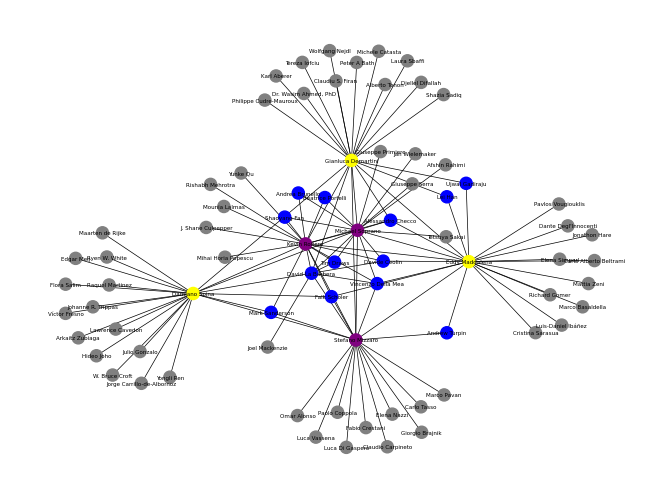

In [3]:
# Ri-caricamento di nodes.csv e edges.csv per permettere l'esecuzione del codice partendo dai dati già scaricati
# (senza dover quindi eseguire i punti 1 e 2 per cui servirebbe la account key di SerpAPI)
df_nodes = pd.read_csv("data/nodes.csv")
df_edges = pd.read_csv("data/edges.csv")

# Funzione per impostare il colore di ciascun nodo in base al grado
def setNodecolorList(graph):
    # Calcolo del grado di ciascun nodo
    node_degrees = dict(graph.degree())
    
    # Definizione delle colorazioni in base al grado
    node_colors = []
    for node, degree in node_degrees.items():
        if degree == 1:
            node_colors.append('gray')
        elif 2 <= degree <= 10:
            node_colors.append('blue')
        elif 11 <= degree <= 20:
            node_colors.append('purple')
        else:
            node_colors.append('yellow')
            
    return node_colors

# Creaazione grafo indiretto da DataFrame e aggiunta degli archi
grafo = nx.from_pandas_edgelist(df_edges, 'author1', 'author2', create_using=nx.Graph())

# Aggiunta dei nodi
for i, row in df_nodes.iterrows():
    grafo.add_node(row['name'], name=row['name'], affiliations=row['affiliations'], author_id=row['author_id'], cited_by=row['cited_by'], interests=row['interests'])

# Serializzazione grafo
with open("graphs/coauthorship_graph.pkl", 'wb') as f:
    pickle.dump(grafo, f)

# Definizione delle colorazioni in base al grado
node_colors = setNodecolorList(grafo)

# Disegno del grafo
pos = nx.spring_layout(grafo)
nx.draw(grafo, pos, with_labels=True, node_size=grafo.number_of_nodes(), node_color=node_colors, font_size=4, width = 0.5)

# Salvataggio del grafo
plt.savefig("visualizations/first_graph.pdf")

# Visualizzazione del grafo
plt.show()

## Punto 4

A partire dal grafo prodotto al punto 3:

    a. Generarne un secondo dove il numero di nodi è lo stesso, mentre il numero di archi è aumentato di 50 utilizzando la  tecnica del Preferential Attachment. Salvare il grafo in locale nella cartella /graphs.
    
    b. Visualizzare e salvare il nuovo grafo come fatto al punto 3b.

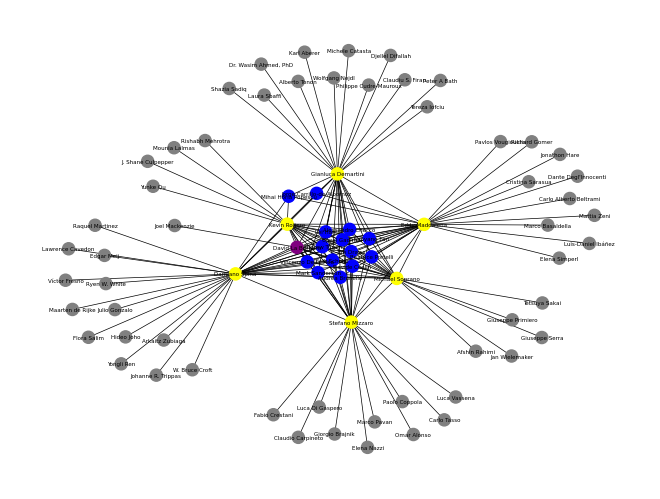

In [4]:
# Funzione per aggiungere 50 archi con la tecnica del Preferential Attachment
def addNodepreferential_attachment(n):
    # Numero di archi da aggiungere
    additional_edges = n
    
    # Calcolo degli archi preferenziali da aggiungere con la funzione preferential_attachment
    pa_edges = list(nx.preferential_attachment(grafo))
    
    # Ordinamento degli archi in base al loro peso
    pa_edges.sort(key=lambda x: x[2], reverse=True)
    
    # Estrazione dei primi 'additional_edges' archi con maggiore peso
    selected_edges = pa_edges[:additional_edges]
    
    # Aggiunta degli archi al grafo esistente
    grafo.add_edges_from([(edge[0], edge[1]) for edge in selected_edges])

    return grafo
    
# Lettura grafo serializzato
with open("graphs/coauthorship_graph.pkl", 'rb') as f:  # notice the r instead of w
    grafo = pickle.load(f)

# Aggiunta archi al grafo
grafo = addNodepreferential_attachment(50)

# Serializzazione grafo
with open("graphs/extended_coauthorship_graph.pkl", 'wb') as f:
    pickle.dump(grafo, f)

# Definizione delle colorazioni in base al grado
node_colors = setNodecolorList(grafo)

# Disegno del grafo
pos = nx.spring_layout(grafo)  # Puoi cambiare l'algoritmo di layout se preferisci
nx.draw(grafo, pos, with_labels=True, node_size=grafo.number_of_nodes(), node_color=node_colors, font_size=4, width = 0.5)

# Salavataggio del grafo
plt.savefig("visualizations/extended_graph.pdf")

# Visualizzazione del grafo
plt.show()

## Punto 5

Per entrambi i grafi prodotti calcolare:

    a. Coefficiente di clustering medio
    b. Centro del grafo
    c. Raggio
    d. Distanza Media
    e. Transitività
    f. Coefficienti Omega e Sigma, per stimare la “small-world-ness”
    g. Riassumere le informazioni in un DataFrame, dove ogni riga rappresenta le informazioni relative ad un grafo, ed ogni colonna le informazioni relative ad una misura calcolata per quel grafo. Salvare nella cartella /results tale DataFrame.

In [31]:
# Funzione per ottenere le misure calcolate sul grafo
def get_Info(grafo):
    new_row = {'coefficiente di clustering medio': nx.average_clustering(grafo), 'centro del grafo': [", ".join(nx.center(grafo))], 'raggio': nx.radius(grafo), 'distanza media': nx.average_shortest_path_length(grafo), 'transitività': nx.transitivity(grafo), 'coefficiente omega': nx.omega(grafo), 'coefficiente sigma': nx.sigma(grafo)}
    return new_row

# Lettura grafo serializzato
with open("graphs/coauthorship_graph.pkl", 'rb') as f:  # notice the r instead of w
    coauthorship_graph = pickle.load(f)

# Lettura grafo serializzato
with open("graphs/extended_coauthorship_graph.pkl", 'rb') as f:  # notice the r instead of w
    extended_coauthorship_graph = pickle.load(f)

# Raccolta delle informazioni relative ai due grafi in due dataframe
df_first_graph_centralities = pd.DataFrame(get_Info(coauthorship_graph))
df_extended_graph_centralities = pd.DataFrame(get_Info(extended_coauthorship_graph))

# Concatenazione dei due dataframe
df_overall_measures = pd.concat([df_first_graph_centralities, df_extended_graph_centralities], ignore_index=True)

# Salvataggio del dataframe
df_overall_measures.to_csv("results/overall_measures.csv", index=False)

## Punto 6

Per entrambi i grafi prodotti calcolare per ogni nodo:

    a. Degree Centrality
    b. Betweenness Centrality
    c. Closeness Centrality
    d. Pagerank
    e. HITS, per calcolare i valori di hubness e authority
    f. Riassumere le due informazioni in un DataFrame per ciascun grafo, dove ogni riga rappresenta le informazioni relative ad un nodo, ed ogni colonna le informazioni relative ad una misura calcolata per quel nodo. Salvare nella cartella /results tali DataFrame.

In [36]:
# Funzione per ottenere le misure calcolate sul grafo
def get_graphInfo(grafo):
    degree_centrality = nx.degree_centrality(grafo)
    betweenness_centrality = nx.betweenness_centrality(grafo)
    closeness_centrality = nx.closeness_centrality(grafo)
    pagerank = nx.pagerank(grafo)
    hits = nx.hits(grafo)

    # Creare un DataFrame
    df = pd.DataFrame({
        'Node': list(grafo.nodes()),
        'Degree Centrality': list(degree_centrality.values()),
        'Betweenness Centrality': list(betweenness_centrality.values()),
        'Closeness Centrality': list(closeness_centrality.values()),
        'Pagerank': list(pagerank.values()),
        'HITS Hubness': list(hits[0].values()),
        'HITS Authority': list(hits[1].values())
    })
    return df

# Lettura grafo serializzato
with open("graphs/coauthorship_graph.pkl", 'rb') as f:  # notice the r instead of w
    coauthorship_graph = pickle.load(f)

# Lettura grafo serializzato
with open("graphs/extended_coauthorship_graph.pkl", 'rb') as f:  # notice the r instead of w
    extended_coauthorship_graph = pickle.load(f)

# Raccolta delle informazioni relative ai due grafi in due dataframe
df_first_graph_centralities = pd.DataFrame(get_graphInfo(coauthorship_graph))
df_extended_graph_centralities = pd.DataFrame(get_graphInfo(extended_coauthorship_graph))

# Salvataggio dei dataframe
df_first_graph_centralities.to_csv("results/first_graph_centralities.csv", index=False)
df_extended_graph_centralities.to_csv("results/extended_graph_centralities.csv", index=False)

## Punto 7

Produrre una visualizzazione interattiva con PyVis dei due grafi con colorazioni di nodi ed archi a piacimento. Salvare i due output in formato HTML nella cartella /visualizations.

In [38]:
# Funzione per impostare il colore di ciascun nodo in base al grado
def setNodecolorDict(graph):
    node_degrees = dict(graph.degree())
    node_colors_options = {}
    i = 1

    # Definizione delle colorazioni in base al grado
    for node, degree in node_degrees.items():
        if degree == 1:
            node_colors_options[i-1] = {'color': 'gray'}
        elif 2 <= degree <= 10:
            node_colors_options[i-1] = {'color': 'blue'}
        elif 11 <= degree <= 20:
            node_colors_options[i-1] = {'color': 'purple'}
        else:
            node_colors_options[i-1] = {'color': 'yellow'}
        i += 1
    
    # Aggiornamento delle opzioni del colore dei nodi
    for i, options in node_colors_options.items():
        nt.nodes[i].update(options)

    return nt
    
# Lettura grafo serializzato
with open("graphs/coauthorship_graph.pkl", 'rb') as f:  # notice the r instead of w
    coauthorship_graph = pickle.load(f)

# Lettura grafo serializzato
with open("graphs/extended_coauthorship_graph.pkl", 'rb') as f:  # notice the r instead of w
    extended_coauthorship_graph = pickle.load(f)

# Creazione visualizzazione interattiva
nt = Network('1000px', '1000px')

# Per rendere la visualizzione più chiara, gli archi non assumono lo stesso colore dei nodi
nt.inherit_edge_colors(False)

# Creazione e salvataggio primo grafo interattivo
nt.from_nx(coauthorship_graph)
nt = setNodecolorDict(coauthorship_graph)
nt.save_graph("visualizations/interactive_first_graphs.html")

# Creazione e salvataggio grafo esteso interattivo
nt.from_nx(extended_coauthorship_graph)
nt = setNodecolorDict(extended_coauthorship_graph)
nt.save_graph("visualizations/interactive_extended_graphs.html")